## Support Vector Machine  with Squared Hinge Loss function - Compare to Scikit-Learn

Elham Rezvani
SML-spring2018

In [1]:
#Load necessary packages
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import math
from scipy.linalg import eigh as largest_eigh
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from IPython.core.debugger import Tracer
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
#Import and standardize the data, and convert y to + 1 and -1 

spam = pd.read_table('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data', sep=' ', header=None) 
spam = np.array(spam)
spam.shape
x = spam[:,0:-1]
y = spam[:,-1]
std_scaleX = StandardScaler().fit(x)
x = std_scaleX.transform(x)
y = y *2 -1

#Separate data into test set and train set, where each set has the same proportion of spam and not spam

def splitTestTrain(x, y, testPCT):
    # x is an array of features
    # y is an array of response variables
    # testPCT is the percent of the dataset that you would like to be included in the test set. The remainder is in the training set
    # Output: A test set including features and response, and a training set inclduing features and response. T
    sss = StratifiedShuffleSplit(n_splits=1, test_size=testPCT, random_state=0)
    for train_index, test_index in sss.split(x,y):
        xTrain, xTest = x[train_index], x[test_index]
        yTrain, yTest = y[train_index], y[test_index]
        return (xTrain, xTest,yTrain, yTest)
    
xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.25)

**The below functions implement the following functions:**
  
Objective function of the squared hinge loss function:
$$ F(\beta) = \frac{1}{n} \sum_{i=1}^n(max(0,1-y_ix_i^T\beta))^2 + \lambda||\beta||_2^2$$

Gradient of the squared hinge loss function:
$$ \nabla F(\beta)=\frac{-2}{n} \sum_{i=1}^n\bigl(y_ix_i  * max(0,1−y_ix_i^Tβ)\bigr) + 2\lambda\beta$$

In [3]:
# To implement SVM with squared hinge loss we need to develop a fast gradient descent algorithm. 
# Our fast gradient descent algorithm relies on several input functions including:
# - computegrad: computes the gradient of the squared hinge loss function at a given point beta
# - objfunc: computes the objective function
# - backtracking function: computes the step size in each iteration of fast gradient descent algorithm

#Initialize Gradient Calculation function
def computegrad(betas, lam, x, y):
    #betas: point at which gradient calculation occurs
    #lam: lambda paramater, as defined by user
    #x: feature vector
    #y: response vector
    #output: gradient
    Maxes = np.maximum(np.zeros(y.shape[0]),(1- (y*np.dot(x,betas))))
    grad = np.sum((x.T*y)*Maxes, axis = 1)
    grad = -2* grad/x.shape[0] + 2 * lam * betas
    return(grad)

def objfunc(betas, lam, x, y):
    #betas: point at which evalution of objective function occurs
    #lam: lambda paramater, as defined by user
    #x: feature vector
    #y: response vector
    #output: value of objective function
    Maxes = np.maximum(np.zeros(y.shape[0]),(1- (y*np.dot(x,betas))))
    obj = sum(Maxes**2)/x.shape[0] + lam * np.linalg.norm(betas)**2
    return(obj)

def backtracking( betas,lam,x, y, t, alpha = 0.5, gamma = 0.8, maxIter = 100):
    # betas = current point
    # lam  = lambda parameter 
    # x = array of feature data
    # y = array of response data
    # t = starting step size
    # alpha = constant used to define sufficient decrease condition
    # gamma = fraction by which we drecrease t if the previous T doesn't work
    # maxIter = maximum iterations for algorithm
    #output = t, the step size to use

    grad_b = computegrad(betas = betas, lam = lam , x=x, y=y)
    norm_grad_b = np.linalg.norm(grad_b)
    found_t = 0
    iters = 0
    t = deepcopy(t)
    while found_t == 0 and iters < maxIter:
        if objfunc(betas = (betas-t*grad_b), lam = lam, x=x, y=y) < objfunc(betas = betas, lam = lam , x=x , y=y)-alpha*t*norm_grad_b**2:
            found_t = 1 
        else:
            t *= gamma
            iters += 1
    return(t)

def mylinearsvm(betas, lam, x,  y,  alpha = .5, gamma = .5, maxIter = 200):
    # betas = current point
    # lam  = lambda parameter 
    # x = array of feature data
    # y = array of response data
    # alpha = constant used to define sufficient decrease condition within the backtracking function
    # gamma = fraction by which we drecrease t if the previous T doesn't work, within the backtracking function
    # maxIter = maximum iterations for algorithm
    # output = a vector of betas that corresponds to the minimum value of the objective function
    theta = np.zeros(xTrain.shape[1])
    b_vals = [betas]
    n = x.shape[0]
    n1 =  x.shape[1]
    
    #Calculate initial step size
    MaxEigVal = largest_eigh(np.dot(1/n*x.T, x), eigvals= (n1-1, n1-1))[0]
    StepInit = 1/(MaxEigVal + lam)
    
    for i in range(0,maxIter):
        step = backtracking(betas = betas, t = deepcopy(StepInit), lam = lam, x = x, y = y, alpha = alpha, gamma = gamma)
        betaNew = theta - step*computegrad(betas = theta, lam = lam, x = x, y = y)
        b_vals.append(betaNew) 
        theta = betaNew+ (i/(i+3))*(betaNew - betas)
        betas = deepcopy(betaNew)
    return(b_vals)

In [4]:
# This set of functions relates to checking and using the output of SVM with squared hinge loss. Funcions include:
# ViewGradDescent: to view gradient descent to determine whether it was successful in finding convergence. 
# class_error: to find the classification error that results from the model and a given dataset
# crossValid: for a given array of lambdas, finds the lowest misclassification error and the lambda it is associated with
# makePreds: for a given model and test set, make predictions
def viewGradDescent(betas, lam, x, y):
    # betas = array of betas created by mySVM function 
    # lam = lambda used in creation of betas above
    # x = x array used in creation of betas above
    # y = y array used in creation of betas above
    #output = plot of objective value of squared hinge loss function given parameters above. Used to demonstrat whether or not SVM converged
    objVals = []
    for i in range(0,len(betas)):
        objVals.append(objfunc(betas = betas[i], lam = lam, x = x, y = y))
    plt.plot(range(len(objVals)), objVals, label = "mySVM")
    plt.legend(loc = "upper right")
    return

def class_error (betaStar, x , y): 
    #Inputs:
    # betaStar = betas corresponding to fitted model (last row of betas created by mysvm function)
    # x = array of features you wish to find misclassification error
    # y = array of response you wish to find misclassification error
    #Output: Caluclation of percent of predictions for which the model was incorrect
    pred = (-x.dot(betaStar)) > 0 
    pred = pred*2- 1 # Convert to +/− 1 
    error = 1- np.mean(pred !=y)
    return error

def crossValid(xTrain, yTrain, xTest, yTest, lambdas):
    #Inputs:
    # xTrain and yTrain = array of features and responses you wish to use to fit the model
    # xTest and yTest = array of features you wish to use to test the model
    # lambdas: array of lambdas you wish to use    #Output: Caluclation of percent of predictions for which the model was incorrect
    # outputs:
    #     array of errors associatd with lambdas
    #     the value of lambda associated with the lowest misclassification error
    #     the value of the lowest misclassification error
    
    #Initialize variables
    betaTrack = (np.zeros(xTrain.shape[1]))
    errorTrack = np.zeros(len(lambdas))
   
    #Fit model for given value of lambda using training data 
    for i in lamdas:
        Betas = mylinearsvm(betas = np.zeros(xTrain.shape[1]), x=xTrain,  y=yTrain, lam = i, maxIter = 100)[-1]
        betaTrack = np.vstack((betaTrack, Betas))
    betaTrack = betaTrack[1:]
   
    #Caluclate predictions and errors for test data
    for i in range(0,len(betaTrack)):
            pred = 1/(1+np.exp(-xTest.dot(betaTrack[i]))) > 0.5 
            pred = pred*2- 1 # Convert to +/− 1 
            errorTrack[i] = np.mean(pred !=yTest)
    
    # Plot errors and return best value of lambda and corresponding error
    bestLam = lamdas[np.argmin(errorTrack,0)]
    minError = np.min(errorTrack)
    fig, ax = plt.subplots()
    ax.plot(lamdas,errorTrack, 'r-')
    plt.xlabel('Lambda')
    plt.ylabel('Misclassification Error')
    ax.plot()
    plt.xscale('log')
    plt.title('Misclassification Error vs Lambda')
    return errorTrack, bestLam, minError

def makePreds(x, betas):
    #inputs:
    #Features that you want to make predictions for
    #betas =  model that you want to use to make predictions
    #output: prediction for each of n rows in your xTest set
    pred = 1/(1+np.exp(-x.dot(betas))) > 0.5 
    pred = pred*2- 1 # Convert to +/− 1 
    return(pred)


The Lowest error found using cross validation is 0.0738488271069 and it corresponds to a lambda of 0.1


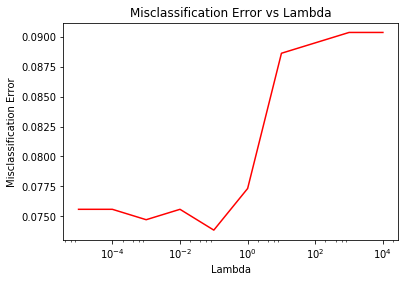

In [5]:
## Run above functions to find the lowest misclassification error and it's corresponding lambda

lamdas = np.array([.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000])
Errors, BestLam, LowestError = crossValid(xTrain, yTrain, xTest, yTest, lambdas = lamdas)
print('The Lowest error found using cross validation is', LowestError,'and it corresponds to a lambda of', BestLam)

In [6]:
#Fit a model using our best lambdas
betas = mylinearsvm(betas = np.zeros(xTrain.shape[1]), x= xTrain,  y= yTrain, lam = BestLam, maxIter = 1000)
betas[-1]
#calculate misclassification error assocated with model, and make predictions
Train_error = class_error(betas[-1], xTrain, yTrain)
Test_error = class_error(betas[-1], xTest, yTest)
print("The misclassifciation error on the training set is:", Train_error)
print("The misclassifciation error on the test set is:", Test_error)
mySVMPreds = makePreds(xTest, betas[-1])

The misclassifciation error on the training set is: 0.0866666666667
The misclassifciation error on the test set is: 0.0729800173762


In [7]:
#Adjust lambda to reflect the different objective function that Scikit-Learn uses
def convertLam(lam):
    convertedLam = 1/(2*xTrain.shape[0]*lam)
    return(convertedLam)

In [8]:
#Fit scikit learn model and generate coefficients and predictions
cbl = convertLam(BestLam)
cbl
model = LinearSVC(C = cbl, fit_intercept = False)
model.fit(xTrain,yTrain)
sklcoef = model.coef_
sklcoef = sklcoef[0,:]
sklPreds = model.predict(xTest)

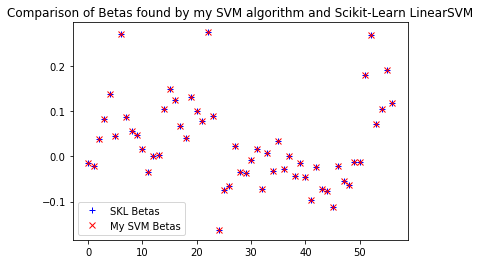

In [9]:
#Plot comparing scikit learn coefficients and mysvm coefficients
%matplotlib inline
plt.plot(range(len(sklcoef)), sklcoef, 'b+' , label ="Scikit-Learn LinearSVM Betas")
plt.plot(range(len(betas[-1])), betas[-1], 'rx' ,label = "mysvm Betas")
plt.legend( ["SKL Betas ", "My SVM Betas"])
plt.title("Comparison of Betas found by my SVM algorithm and Scikit-Learn LinearSVM")


In [10]:
print('The proportion of predictions where mySVM predictions are the same as the Scikit Learn Model predictions is:',np.mean(sklPreds == mySVMPreds))

The proportion of predictions where mySVM predictions are the same as the Scikit Learn Model predictions is: 1.0
